In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
import os
import sys
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools
import photxspec

### construct samples

In [3]:
# inputs
redshift = 0.7
sim = TNGSim('TNG300-3', redshift=redshift) # initialize simulation

sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]  # 5 redshift error bins in SPHEREx

nslices = 11
nbins = 20
thetamin = 0.001
thetamax = 4.

In [4]:
%%time
dxs = []
xcorrs = []
gal_pos_specs = []
gal_pos_phots = []
for i, sigma_z in enumerate(sigma_zs):
    print(sigma_z)
    # spectroscopic sample
    gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
    gal_pos_spec -= sim.boxsize / 2
    gal_pos_specs.append(gal_pos_spec)

    # construct photometric samples and compute cross correlations
    res = photxspec.compute_photxspec(gal_pos_spec, redshift, sigma_z, sim.boxsize, nslices=nslices,
                                 nbins=nbins, thetamin=thetamin, thetamax=thetamax)
    dxs.append(res['dx'])
    xcorrs.append(res['xcorrs'])
    gal_pos_phots.append(res['gal_pos_phots'][0])

0.003
 number density for SPHEREx at z=0.7: 7.05e-05 (h/Mpc)^3 
target number of subhalos: 607
0.01
 number density for SPHEREx at z=0.7: 9.37e-04 (h/Mpc)^3 
target number of subhalos: 8072
0.03
 number density for SPHEREx at z=0.7: 2.94e-03 (h/Mpc)^3 
target number of subhalos: 25328
0.1
 number density for SPHEREx at z=0.7: 4.95e-03 (h/Mpc)^3 
target number of subhalos: 42644
0.2
 number density for SPHEREx at z=0.7: 2.50e-03 (h/Mpc)^3 
target number of subhalos: 21537
CPU times: user 16min 8s, sys: 906 ms, total: 16min 9s
Wall time: 6min 27s


In [5]:
# unpack results: thetaavg and slice_centers are the same for all sigma_z
thetaavg = res['thetaavg']
slice_centers = res['slice_centers']

In [6]:
save_info = {
    'thetaavg' : thetaavg,
    'slice_centers' : slice_centers,
    'losbins' : res['losbins'],
    'dxs' : dxs,
    'xcorrs' : xcorrs,
    'gal_pos_phots' : gal_pos_phots,
    'gal_pos_specs' : gal_pos_specs
}
np.save(f'/scratch/08811/aew492/small-scale_cross-corrs/xcorrs/xcorr_res_spherex-sigma-zs_z07.npy', save_info)

In [9]:
d = np.load(f'/scratch/08811/aew492/small-scale_cross-corrs/xcorrs/xcorr_res_spherex-sigma-zs_z0.npy',
           allow_pickle=True).item()
thetaavg, slice_centers, losbins, dxs, xcorrs, gal_pos_phots, gal_pos_specs = d.values()

In [7]:
# color map and theta/r conversion for plotting
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, redshift)
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, redshift)

Text(0.5, 1.05, '$w(\\theta)$ cross-corr, phot. sample x spec. slices, z=0.7')

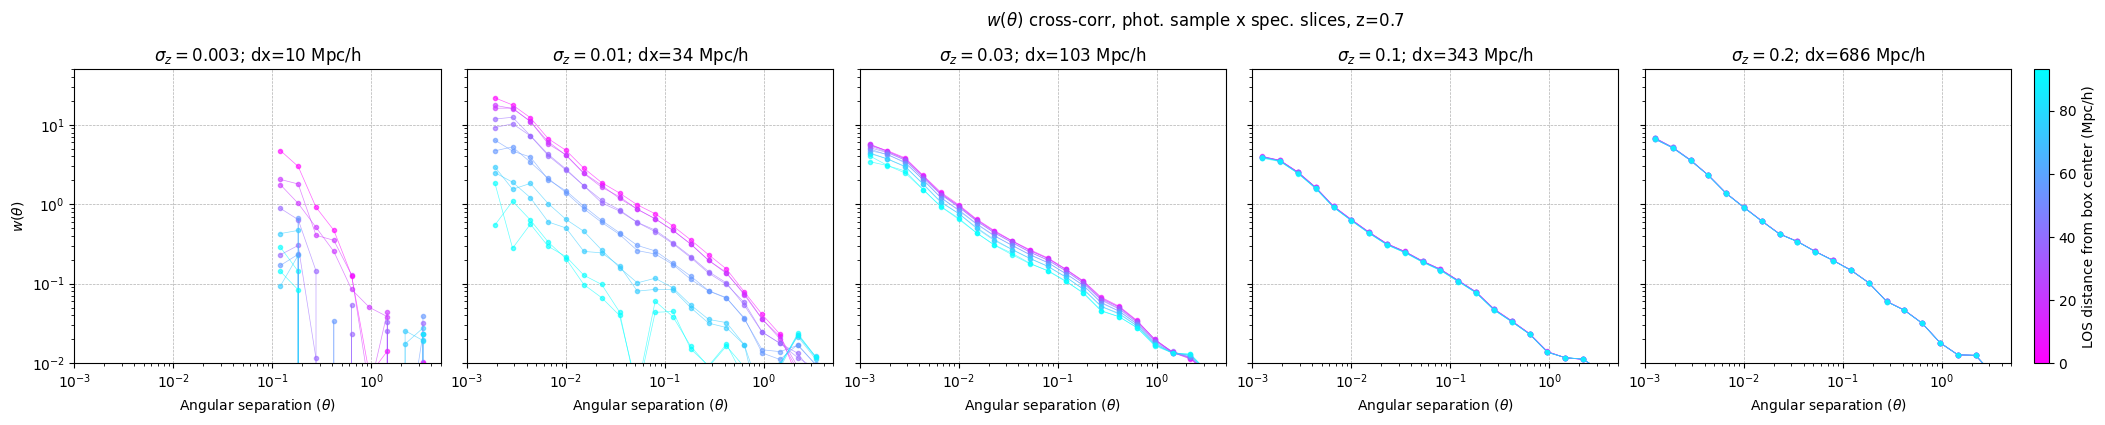

In [9]:
fig = plt.figure(figsize=(24,4))
axs = []

# one figure for each sigma_z
for i, xcorr in enumerate(xcorrs):
    axs.append(fig.add_subplot(1,5,i+1))
    # cross correlation in each slice for this sigma_z
    for j, xcorr_slice in enumerate(xcorr):
        axs[i].plot(thetaavg, xcorr_slice, marker='.', ls='-', lw=0.5, alpha=0.6, c=smap.to_rgba(np.abs(slice_centers[j])))
    axs[i].set_xlabel(r'Angular separation ($\theta$)')
    axs[i].set_xlim(1e-3,5.)
    axs[i].set_ylim(1e-2,5e1)
    axs[i].loglog()
    axs[i].set_title(r'$\sigma_z=$'+f'{sigma_zs[i]}; dx={dxs[i].value:.0f} Mpc/h')
    axs[i].grid(ls='--', lw=0.5)
    if i > 0:
        axs[i].set_yticklabels([])

axs[0].set_ylabel(r'$w(\theta)$')
fig.tight_layout()
fig.colorbar(smap, ax=axs, pad=0.01, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w(\theta)$ cross-corr, phot. sample x spec. slices, 'f'z={redshift}', y=1.05)

In [10]:
weights = np.array([
    photxspec.get_photometric_weights(gal_pos_phot_, sim.boxsize, nslices=nslices) \
    for gal_pos_phot_ in gal_pos_phots
])

In [11]:
# convert from angle theta to separation r
ravg = theta_to_r_comov_(thetaavg)

Text(0.5, 1.05, '$w(\\theta)$ cross-corr, photometric sample x spectroscopic slices, z=0.7')

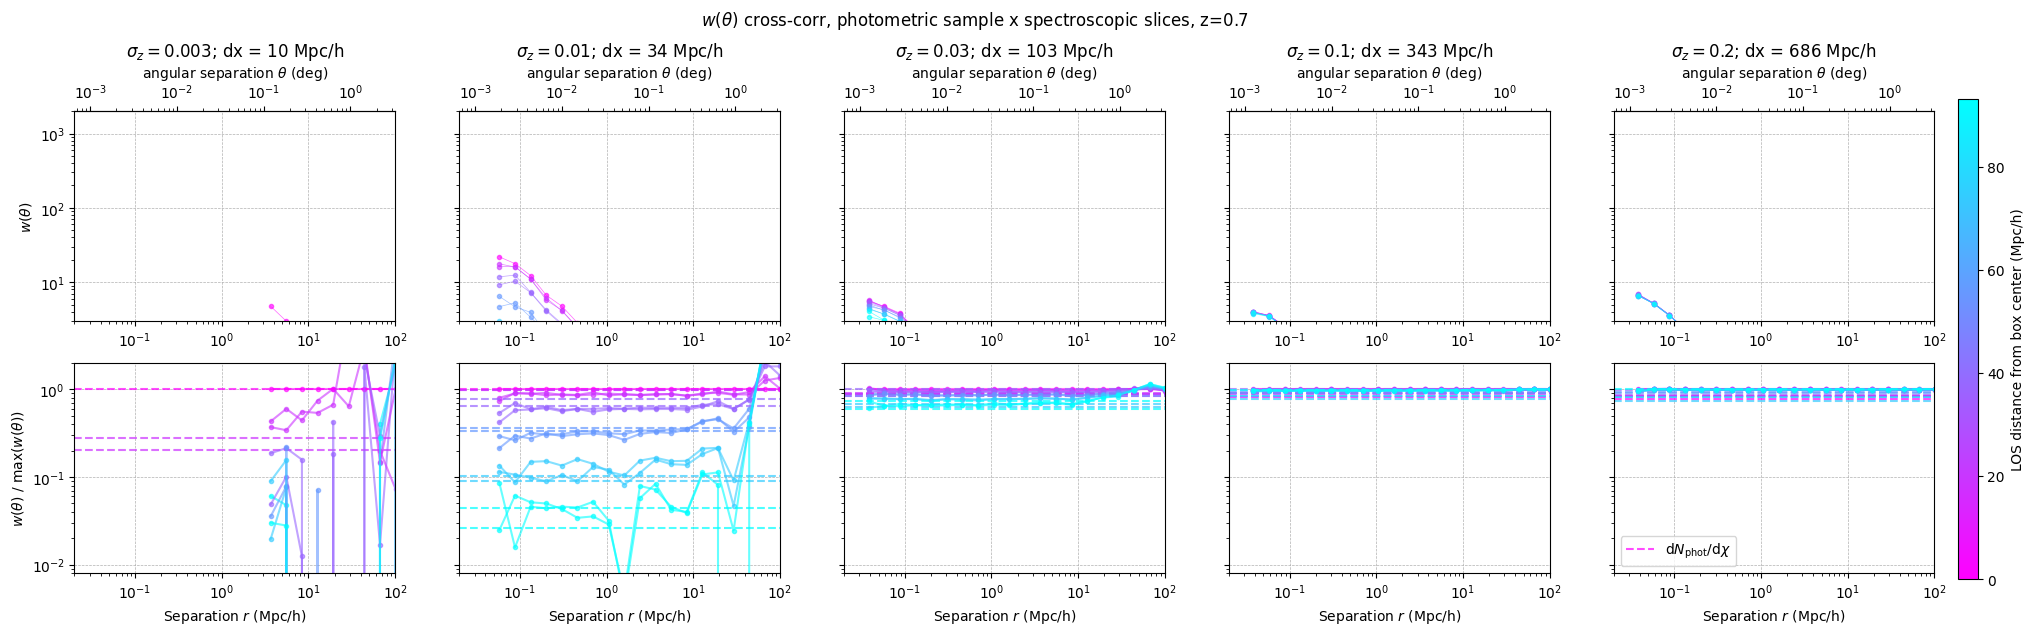

In [12]:
fig = plt.figure(figsize=(24,6))
axs = {}

for i, xcorr in enumerate(xcorrs):
    axs[i] = fig.add_subplot(2,5,i+1)
    for j, xcorr_slice in enumerate(xcorr):
        axs[i].plot(ravg, xcorr_slice, marker='.', ls='-', lw=0.5, alpha=0.6, c=smap.to_rgba(np.abs(slice_centers[j])))
    secax = axs[i].secondary_xaxis('top', functions=(r_comov_to_theta_, theta_to_r_comov_))
    secax.set_xlabel(r'angular separation $\theta$ (deg)')
    axs[i].set_title(r'$\sigma_z=$'+f'{sigma_zs[i]}; dx = {dxs[i].value:.0f} Mpc/h', y=1.22)
    axs[i].set_xlim(.02,100)
    # axs[i].set_ylim(4e-3,3e1)
    axs[i].set_ylim(3,2e3)
    axs[i].loglog()
    axs[i].grid(ls='--', lw=0.5)
    if i == 0:
        axs[i].set_ylabel(r'$w(\theta)$')
    else:
        axs[i].set_yticklabels([])
        
for i, xcorr in enumerate(xcorrs):
    axs[i] = fig.add_subplot(2,5,i+6)
    
    # normalize each curve by the c.f. at the box center
    xcorr_center = xcorr[len(xcorr)//2]
    
    for j, xcorr_slice in enumerate(xcorr):
        axs[i].plot(ravg, xcorr_slice / xcorr_center, marker='.', ls='-', alpha=0.6,
                c=smap.to_rgba(np.abs(slice_centers[j])))
        label = r'd$N_\mathrm{phot}$/d$\chi$' if (i==4) and (j==5) else ''
        axs[i].axhline(weights[i,j] / np.amax(weights[i]), marker='None', ls='--', alpha=0.7,
                       c=smap.to_rgba(np.abs(slice_centers[j])), label=label)
    axs[i].set_xlabel(r'Separation $r$ (Mpc/h)')
    axs[i].set_xlim(.02,100)
    axs[i].set_ylim(8e-3, 2)
    axs[i].loglog()
    axs[i].grid(ls='--', lw=0.5)
    if i == 0:
        axs[i].set_ylabel(r'$w(\theta)$ / max$(w(\theta))$')
    else:
        axs[i].set_yticklabels([])
    if i == 4:
        axs[i].legend()

cax = fig.add_axes([.91, 0.1, 0.008, 0.8])
fig.colorbar(smap, cax=cax, aspect=100, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w(\theta)$ cross-corr, photometric sample x spectroscopic slices, 'f'z={redshift}', y=1.05)

### compare to linear theory

In [13]:
# inputs
ell = np.logspace(0, 6, 1000)
nx = 500
r_edges = np.logspace(np.log10(1), np.log10(100.), 21) # !! used ONLY to calculate the bias
bias_range = (8,-5)
nphotslices = 11

In [14]:
wlin_theories = []
for i, sigma_z in enumerate(sigma_zs):
    print(sigma_z)
    wlin_pred = photxspec.wlin_theory(gal_pos_phots[i], gal_pos_specs[i], sim, thetaavg,
                                                ell, nx, r_edges, bias_range, nphotslices)
    wlin_theories.append(wlin_pred)

0.003
0.01
0.03
0.1
0.2


In [15]:
# number of galaxies
nspec = [len(x) for x in gal_pos_specs]
nphot = [len(x) for x in gal_pos_phots]
nspec, nphot

([607, 8072, 25328, 38274, 21537], [58, 3248, 21648, 37712, 21446])

/tmp/ipykernel_3502066/907467313.py:34: RuntimeWarning: divide by zero encountered in divide
  axs[i].plot(thetaavg, xcorr_slice / wlin_theories[i][j], marker='.', ls='None', alpha=0.6, c=c)


Text(0.5, 1.06, '$w_x(\\theta)$ phot. sample x spec. slices, $z=$0.7: comparison to linear prediction')

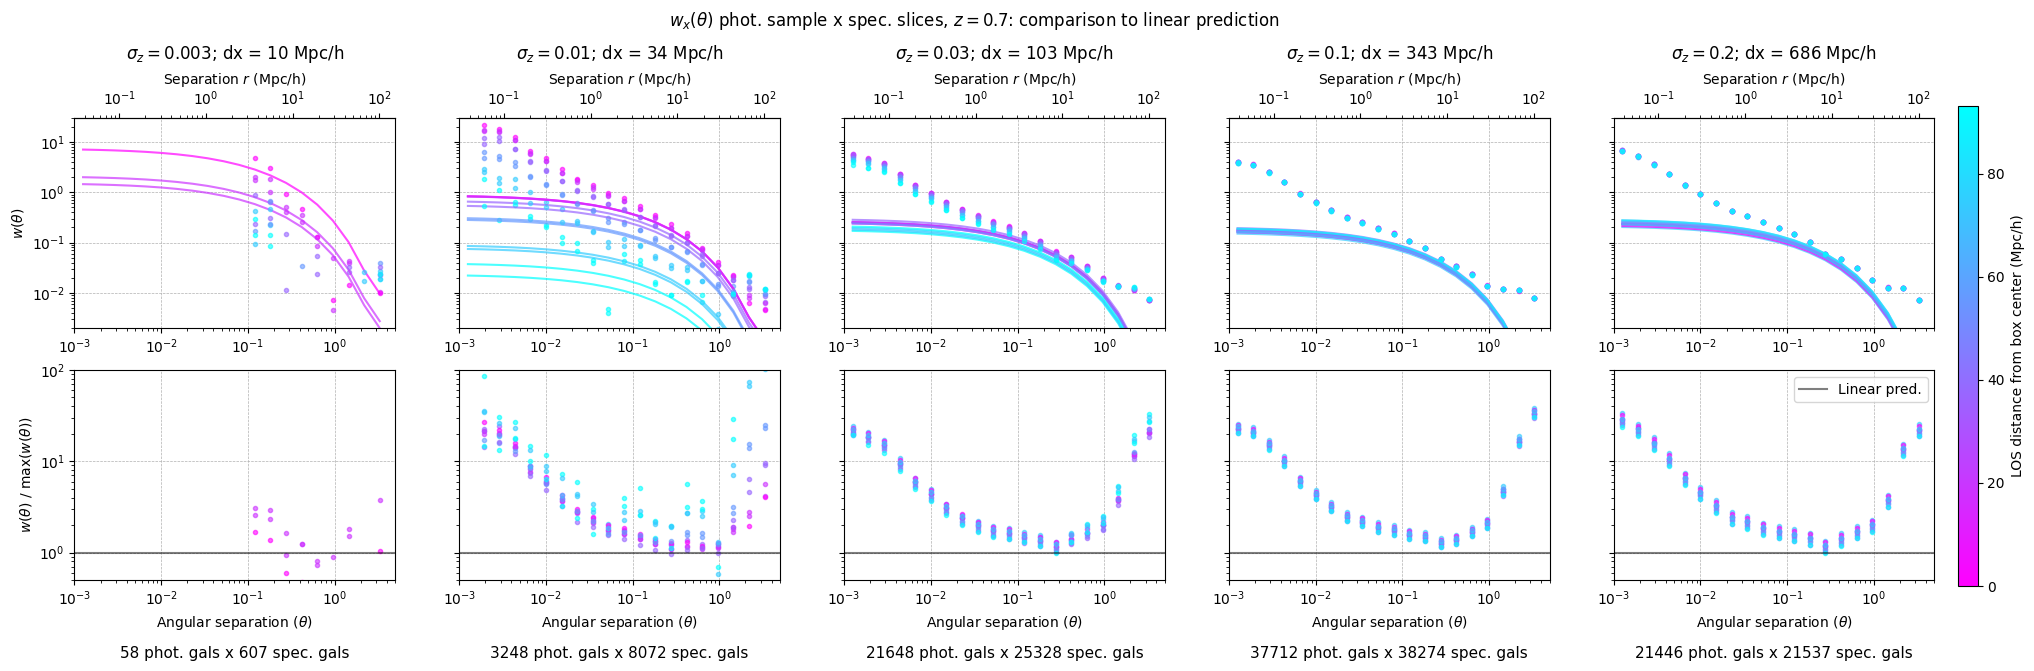

In [16]:
fig = plt.figure(figsize=(24,6))
axs = {}

for i, xcorr in enumerate(xcorrs):
    axs[i] = fig.add_subplot(2,5,i+1)
    
    for j, xcorr_slice in enumerate(xcorr):
        c = smap.to_rgba(np.abs(slice_centers[j]))
        label_data = f'Estimator' if j==5 else ''
        label_pred = f'Linear pred.' if j==5 else ''
        axs[i].plot(thetaavg, xcorr_slice, marker='.', ls='None', alpha=0.6, c=c, label=label_data)
        axs[i].plot(thetaavg, wlin_theories[i][j], ls='-', alpha=0.7, c=c, label=label_pred)
        
    secax = axs[i].secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    secax.set_xlabel(r'Separation $r$ (Mpc/h)')
    axs[i].set_title(r'$\sigma_z=$'+f'{sigma_zs[i]}; dx = {dxs[i].value:.0f} Mpc/h', y=1.24)
    axs[i].set_xlim(1e-3,5)
    axs[i].set_ylim(2e-3,3e1)
    axs[i].loglog()
    axs[i].grid(ls='--', lw=0.5)
    if i == 0:
        axs[i].set_ylabel(r'$w(\theta)$')
    else:
        axs[i].set_yticklabels([])
        
for i, xcorr in enumerate(xcorrs):
    axs[i] = fig.add_subplot(2,5,i+6)
    
    # normalize each curve by the c.f. at the box center
    xcorr_center = xcorr[len(xcorr)//2]
    
    for j, xcorr_slice in enumerate(xcorr):
        c = smap.to_rgba(np.abs(slice_centers[j]))
        axs[i].plot(thetaavg, xcorr_slice / wlin_theories[i][j], marker='.', ls='None', alpha=0.6, c=c)
        
    axs[i].set_xlabel(r'Angular separation ($\theta$)')
    axs[i].text(0.5, -0.35, f'{nphot[i]} phot. gals x {nspec[i]} spec. gals', horizontalalignment='center',
                verticalalignment='center', transform=axs[i].transAxes, fontsize=11)
    axs[i].axhline(1, c='k', alpha=0.5, label='Linear pred.')
    axs[i].set_xlim(1e-3, 5)
    axs[i].set_ylim(0.5, 1e2)
    axs[i].loglog()
    axs[i].grid(ls='--', lw=0.5)
    if i == 0:
        axs[i].set_ylabel(r'$w(\theta)$ / max$(w(\theta))$')
    else:
        axs[i].set_yticklabels([])
    if i == 4:
        axs[i].legend()

cax = fig.add_axes([.91, 0.1, 0.008, 0.8])
fig.colorbar(smap, cax=cax, aspect=100, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w_x(\theta)$ phot. sample x spec. slices, $z=$'f'{redshift}: comparison to linear prediction', y=1.06)